# Algotytm przecinania się odcinków na płaszczyźnie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Przydatne funkcje 

In [55]:
np.random.seed(100)

def draw_example_1():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()

def draw_segments(lines):
    vis = Visualizer()
    vis.add_line_segment(lines)
    vis.show()

def draw_intersecitons(segments, intersections):
    vis = Visualizer()
    points = [i[0] for i in intersections]
    vis.add_line_segment(segments)
    vis.add_point(points, color="red")
    vis.show()

def orientation(a, b, c):
    val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2

def find_intersection(line1, line2):
    x1, y1 = line1[0]
    x2, y2 = line1[1]
    x3, y3 = line2[0]
    x4, y4 = line2[1]
    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if det == 0: return 0
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / det
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / det

    if 0 <= t <= 1 and 0 <= u <= 1:
        intersection_x = x1 + t * (x2 - x1)
        intersection_y = y1 + t * (y2 - y1)
        return (intersection_x, intersection_y)
    else:
        return None

In [3]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    res = []
    for _ in range(n):
        x1 = np.random.uniform(0, max_x)
        x2 = np.random.uniform(0, max_x)
        y1 = np.random.uniform(0, max_y)
        y2 = np.random.uniform(0, max_y)
        if x1 > x2: x1, x2 = x2, x1
        res.append(((x1, y1), (x2, y2)))
    return res

In [4]:
a = [((0.6728110599078341, 9.027649769585256),
  (9.11520737327189, 0.548387096774194)),
 ((0.6543778801843319, 5.580645161290324),
  (3.3456221198156686, 7.958525345622123)),
 ((1.4654377880184333, 4.198156682027651),
  (5.078341013824884, 6.686635944700463)),
 ((2.3317972350230414, 2.5576036866359457),
  (8.96774193548387, 8.364055299539173)),
 ((1.576036866359447, 8.935483870967744),
  (7.3271889400921655, 3.9953917050691254)),
 ((0.41474654377880205, 7.921658986175117),
  (3.456221198156682, 1.8202764976958534)),
 ((4.451612903225806, 9.414746543778804),
  (4.488479262672811, 0.32718894009216637)),
 ((0.5622119815668203, 0.8433179723502311),
  (9.152073732718893, 1.87557603686636)),
 ((5.889400921658986, 8.880184331797237),
  (7.953917050691244, 6.428571428571431))]
b = [((0.9308755760368665, 7.479262672811062),
  (9.059907834101383, 7.682027649769587)),
 ((0.7649769585253456, 5.451612903225808),
  (9.705069124423963, 6.539170506912444)),
 ((1.1705069124423964, 4.179723502304149),
  (9.44700460829493, 4.99078341013825)),
 ((0.967741935483871, 2.66820276497696),
  (8.857142857142858, 3.055299539170508)),
 ((1.0414746543778803, 1.4884792626728116),
  (9.188940092165899, 1.8202764976958534))]
c = [((2.2396313364055302, 8.677419354838712),
  (8.4147465437788, 2.281105990783411)),
 ((1.0230414746543781, 7.110599078341016),
  (6.516129032258064, 7.331797235023043)),
 ((1.3732718894009217, 6.078341013824886),
  (7.695852534562212, 6.2442396313364075)),
 ((2.055299539170507, 5.046082949308757),
  (8.617511520737327, 5.654377880184334)),
 ((0.9861751152073732, 4.10599078341014),
  (9.078341013824884, 4.235023041474656)),
 ((0.9308755760368665, 3.239631336405531),
  (8.87557603686636, 3.4792626728110614)),
 ((0.967741935483871, 8.271889400921662),
  (5.1336405529953915, 2.410138248847927))]
d= [((2.110599078341014, 9.193548387096776),
  (2.7557603686635948, 8.769585253456224)),
 ((1.7235023041474657, 7.8479262672811085),
  (5.2073732718894, 8.51152073732719)),
 ((2.4976958525345627, 6.797235023041477),
  (5.2073732718894, 6.152073732718896)),
 ((7.622119815668203, 8.364055299539173),
  (8.4147465437788, 5.709677419354841)),
 ((4.5437788018433185, 3.6082949308755774),
  (9.188940092165899, 7.055299539170509)),
 ((1.6313364055299542, 5.635944700460831),
  (7.751152073732719, 3.2764976958525356)),
 ((1.096774193548387, 1.617511520737328),
  (9.170506912442397, 2.1336405529953923)),
 ((1.7603686635944702, 3.0184331797235036),
  (6.184331797235023, 5.8571428571428585)),
 ((3.824884792626728, 9.322580645161292),
  (7.953917050691244, 4.456221198156683)),
 ((0.8940092165898617, 6.944700460829495),
  (9.2073732718894, 7.884792626728112)),
 ((1.2073732718894008, 3.958525345622121),
  (1.8341013824884795, 0.8617511520737333)),
 ((0.5069124423963136, 2.4285714285714297),
  (7.013824884792626, 9.156682027649772)),
 ((4.875576036866359, 2.8341013824884804),
  (6.792626728110598, 2.870967741935485)),
 ((3.769585253456221, 2.2626728110599084),
  (4.396313364055299, 0.8801843317972355)),
 ((7.824884792626728, 1.1198156682027658),
  (9.023041474654377, 3.3502304147465454)),
 ((2.5161290322580645, 2.3179723502304155),
  (3.19815668202765, 1.1566820276497702)),
 ((6.0921658986175125, 0.91705069124424),
  (7.253456221198157, 1.3594470046082956)),
 ((9.2073732718894, 5.359447004608296),
  (9.834101382488479, 4.032258064516131)),
 ((8.027649769585253, 9.322580645161292),
  (9.262672811059907, 8.585253456221201)),
 ((0.8571428571428572, 9.285714285714288),
  (3.382488479262673, 8.99078341013825))]
e = [((3.5483870967741935, 8.253456221198158),
  (9.2073732718894, 2.6313364055299546)),
 ((1.6129032258064515, 5.396313364055301),
  (8.525345622119815, 8.695852534562214)),
 ((1.4101382488479262, 7.018433179723504),
  (9.170506912442397, 6.539170506912444)),
 ((0.7834101382488479, 3.903225806451614),
  (6.64516129032258, 9.009216589861753))]
f = generate_uniform_sections(100, 100 ,30)
test_examples = [b, e, c, a, d, f]

### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [7]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.109s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [8]:
section = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

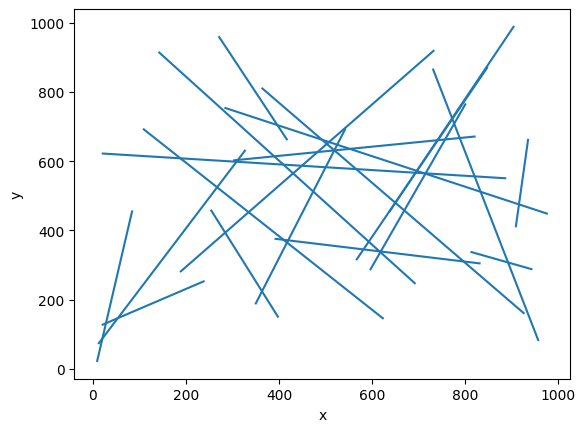

In [9]:
draw_segments(section)

Uzupełnij funkcję ```add_sections``` #interaktywne dodawanie odcinków przez rysowanie myszką (jak?) TODO

In [10]:
def add_sections(n):
    '''
Żeby skorzystać z graficznego wprowadzania odcinków należy wywołać funkcję `draw_app` z argumentem, 
który oznacza liczbę prostych. Wynik można zapisać do zmiennej,
np: `sections = draw_app(10)`.
'''
    %matplotlib tk
    clicks = []

    def onclick(event):
        x = event.xdata
        y = event.ydata
        if x is not None and y is not None:
            clicks.append((x, y))

    res = []
    fig, ax = plt.subplots(figsize = (7,7))
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    while len(clicks) == 0:
        plt.pause(0.1)
    while len(clicks) == 1:
        plt.pause(0.1)
        plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")
    
    plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")
    plt.plot((clicks[-1][0], clicks[-2][0]), (clicks[-1][1], clicks[-2][1]),color="blue")

    while len(clicks) < 2 * n:
        plt.pause(0.1)
        plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")
        if len(clicks) % 2 == 0: 
            plt.plot((clicks[-1][0], clicks[-2][0]), (clicks[-1][1], clicks[-2][1]),color="blue")

    for i in range(0, len(clicks), 2):
        res.append(((clicks[i][0], clicks[i][1]), (clicks[i+1][0], clicks[i+1][1])))

    plt.pause(1)
    plt.close('all')
    %matplotlib inline
    return res

Uzupełnij funkcję ```is_intersection```

In [50]:
def is_intersection(lines):
    endpoints = []
    
    for line in lines:
        endpoints.append((line[0], 'start', line))
        endpoints.append((line[1], 'end', line))

    endpoints.sort()

    active_lines = []

    for point, event, line in endpoints:
        if event == 'start':
            active_lines.append(line)
        else:
            active_lines.remove(line)

        for active_line in active_lines:
            inter = find_intersection(line, active_line)
            if inter:
                return True

    return False

In [51]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.000s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Odpowiedź here

Uzupełnij funkcję ```is_intersection_with_visualization```

In [124]:
def is_intersection_with_visualization(lines): # TODO wizualizacja (jak?)
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    endpoints = []
    vis = Visualizer()
    vis.add_line_segment(lines, color="black")
    ls = {}
    st = []
    end = []
    for line in lines:
        endpoints.append((line[0], 'start', line))
        endpoints.append((line[1], 'end', line))
        # p = vis.add_point(endpoints[-2][0], color = "green")
        # st.append(p)
        # p = vis.add_point(endpoints[-1][0], color = "purple")
        # end.append(p)
    
    end = [i[0] for i in endpoints if i[1] == 'end']
    st = [i[0] for i in endpoints if i[1] == 'start']
    vis.add_point(st, color="green")
    vis.add_point(end, color = "purple")

    endpoints.sort()
    maxY = max(endpoints, key=lambda x:x[0][1])[0][1]
    minY = min(endpoints, key=lambda x:x[0][1])[0][1]
    print(minY, maxY,endpoints[0][0])
    active_lines = []
    # broom = vis.add_line_segment(((endpoints[0][0][0], minY), (endpoints[0][0][0], maxY)), color="orange")
    broom = vis.add_line_segment((endpoints[0][0], endpoints[0][0]))
    
    def make_broom(point, broom):
        vis.remove_figure(broom)
        return vis.add_line_segment(((point[0], minY), (point[0], maxY)), color="orange")
    
    for point, event, line in endpoints:
        broom = make_broom(point, broom)
        if event == 'start':
            active_lines.append(line)
            l = vis.add_line_segment(line, color = "blue")
            ls[line] = l
        else:
            active_lines.remove(line)
            vis.remove_figure(ls[line])

        
        for active_line in active_lines:
            inter = find_intersection(line, active_line)
            if inter:
                broom = make_broom(inter, broom)
                vis.add_point(inter, color = "red")  
                return vis

    return vis


In [129]:
test = add_sections(4)

0.4562211981566826 8.566820276497698 (1.1705069124423964, 8.566820276497698)


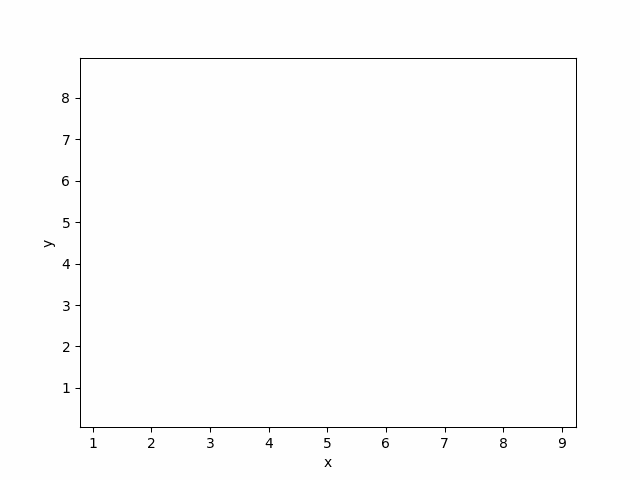

In [130]:
is_intersection_with_visualization(test).show_gif(interval=500)

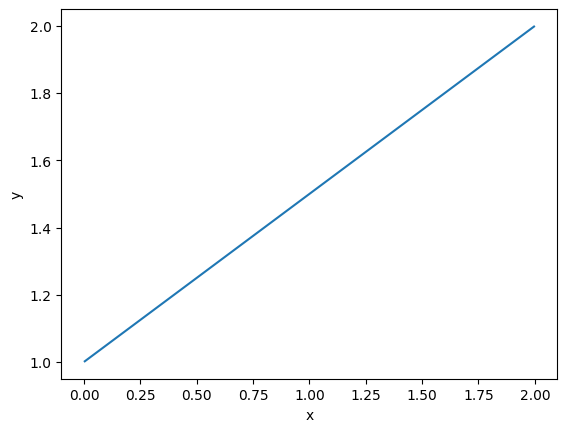

In [70]:
vis = Visualizer()
vis.add_line_segment(((0, 1), (2, 2)))
vis.show()

Uzupełnij funkcję ```find_intersections```

In [53]:
def find_intersections(lines):
    endpoints = []
    
    for line in lines:
        endpoints.append((line[0], 'start', line))
        endpoints.append((line[1], 'end', line))

    endpoints.sort()

    active_lines = []

    intersections = set()

    for point, event, line in endpoints:
        if event == 'start':
            active_lines.append(line)
        else:
            active_lines.remove(line)

        for active_line in active_lines:
            if active_line[0][0] > line[0][0]: continue
            inter = find_intersection(line, active_line)
            if inter:
                intersections.add((inter, lines.index(line) ,lines.index(active_line)))

    return list(intersections)

In [54]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: 

ZeroDivisionError: float division by zero

Uzupełnij funkcję ```find_intersections_with_visualization```

In [18]:
def find_intersections_with_visualization(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

Odpowiedź here

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

Odpowiedź here

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

Odpowiedź here

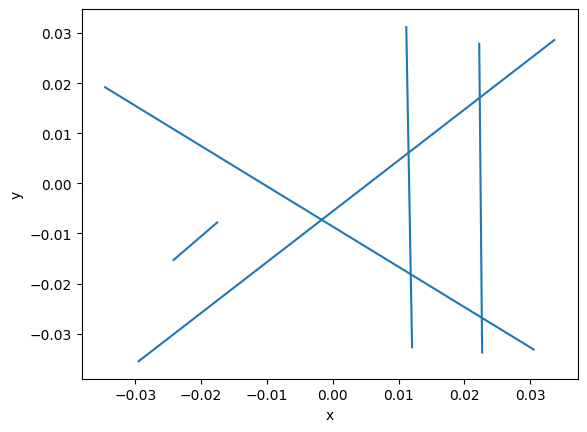

In [20]:
s = '''
-0.034729840063279685 0.019299425704806472 0.030693547033494514 -0.03327410370695825
-0.02962903361166678 -0.03563317233440923 0.03379838574317193 0.028735700214610402
0.01117741800123645 0.031431778645982955 0.012064514775429996 -0.032937093903036674
0.02226612767865581 0.028061680606767267 0.022709676065752582 -0.03394812331480138
-0.024306452966505486 -0.015412584099115098 -0.017431452966505487 -0.007661358608919019'''

s = s.split()
s = [float(i) for i in s]
s = [ ((s[i], s[i+1]), (s[i+2], s[i+3])) for i in range(0, len(s), 4)]
draw_segments(s)

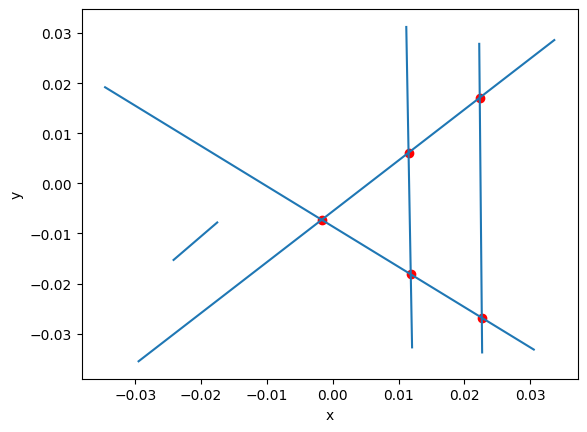

In [37]:
draw_intersecitons(s, find_intersections(s))

In [38]:
find_intersections(s)

[((0.022344451130778698, 0.017111754849194874), 3, 1),
 ((0.011526074740254206, 0.006132801296422435), 2, 1),
 ((0.011860591253227503, -0.018140143229495413), 2, 0),
 ((-0.0016743790516658072, -0.007263586832941066), 1, 0),
 ((0.022658670631229855, -0.026817363547212175), 3, 0)]

In [23]:
['-0.0016743790516658117 -0.007263586832941072 1 2', '0.011526074740254208 0.006132801296422439 2 3', '0.011860591253227505 -0.018140143229495424 1 3', '0.022344451130778698 0.01711175484919488 2 4', '0.022658670631229855 -0.026817363547212168 1 4']

['-0.0016743790516658117 -0.007263586832941072 1 2',
 '0.011526074740254208 0.006132801296422439 2 3',
 '0.011860591253227505 -0.018140143229495424 1 3',
 '0.022344451130778698 0.01711175484919488 2 4',
 '0.022658670631229855 -0.026817363547212168 1 4']

[((4.922310149364795, 5.006321829300639), 1, 0),
 ((3.98919451513731, 4.12133250285566), 2, 1),
 ((5.804269850021889, 4.097760095909107), 2, 0)]

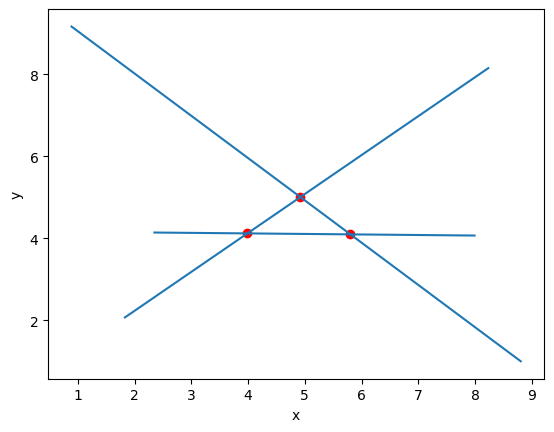

In [39]:
lines = add_sections(3)
draw_intersecitons(lines, find_intersections(lines))
find_intersections(lines)

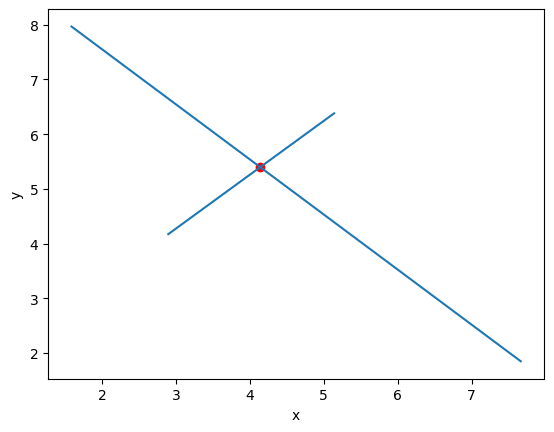

In [25]:
draw_intersecitons(lines, find_intersections(lines))

In [26]:
find_intersections(lines)

[((4.1407113077579885, 5.39678756164256), 1, 0)]

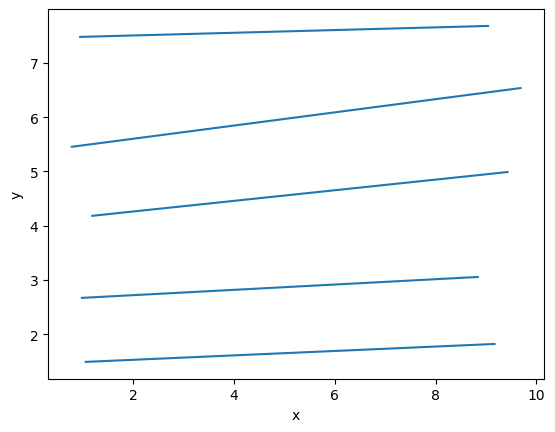

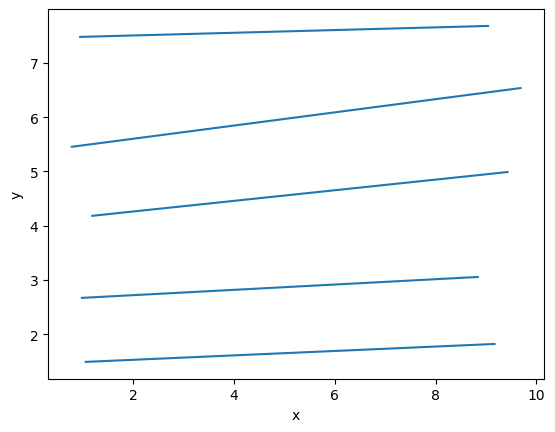

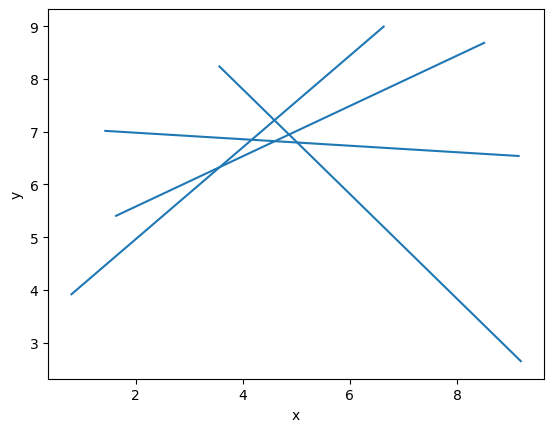

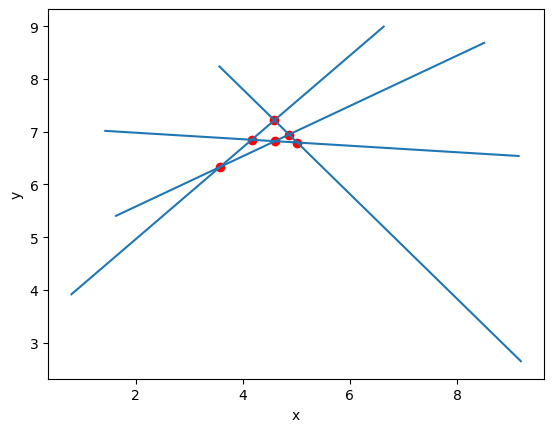

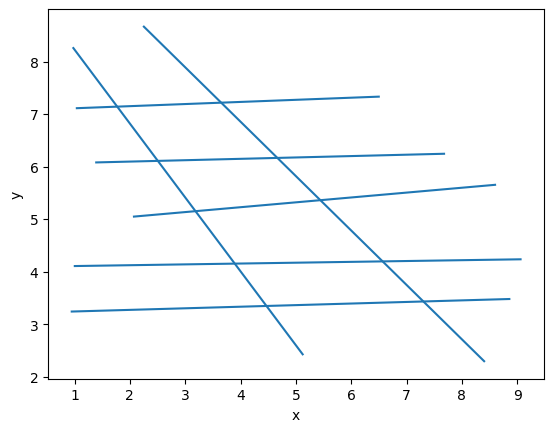

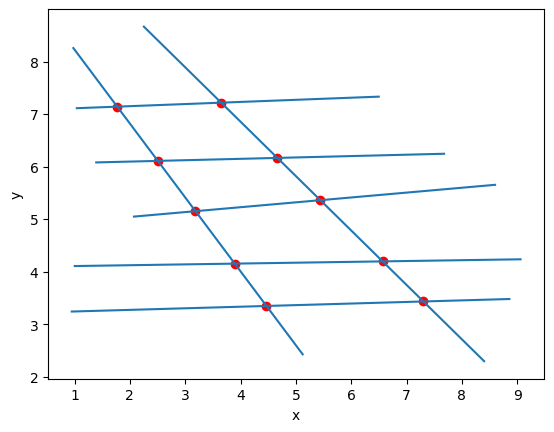

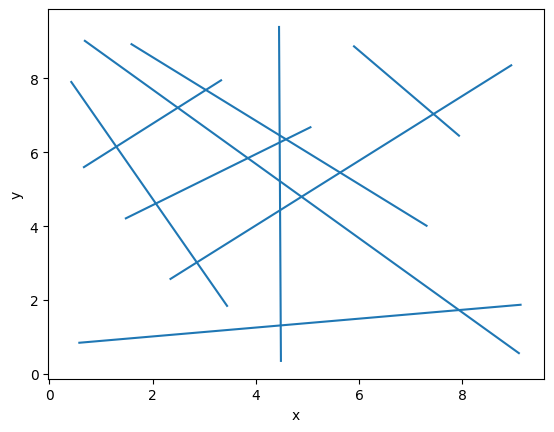

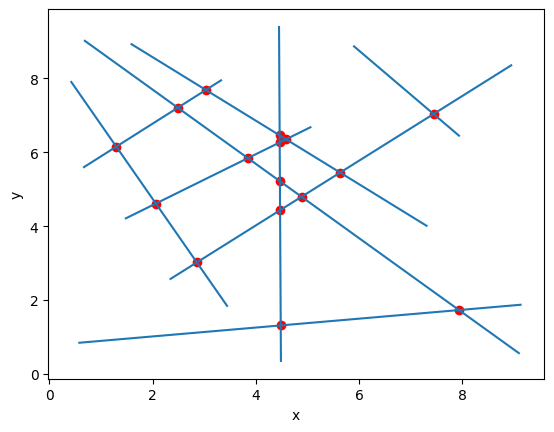

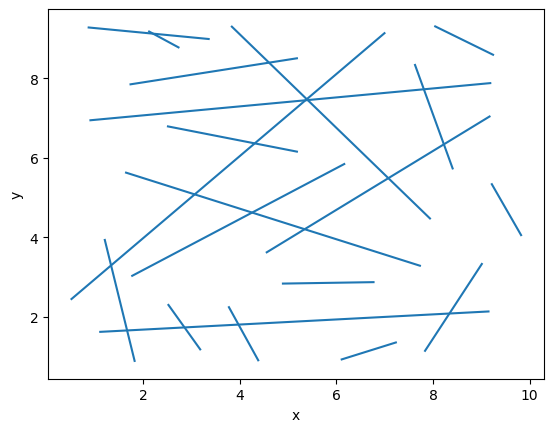

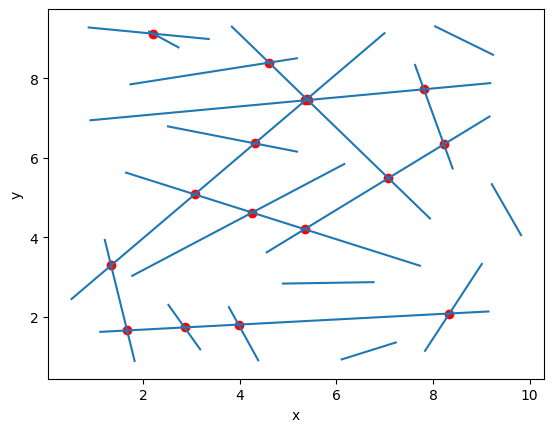

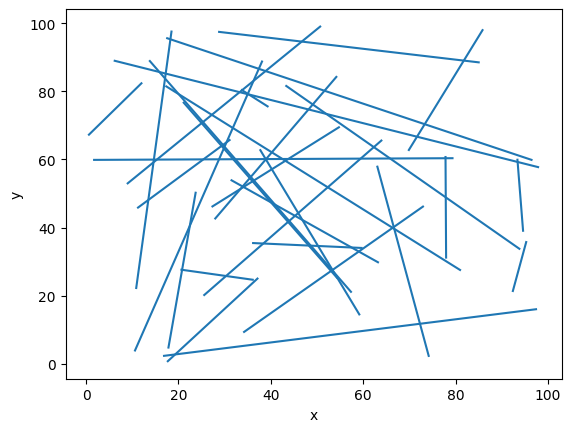

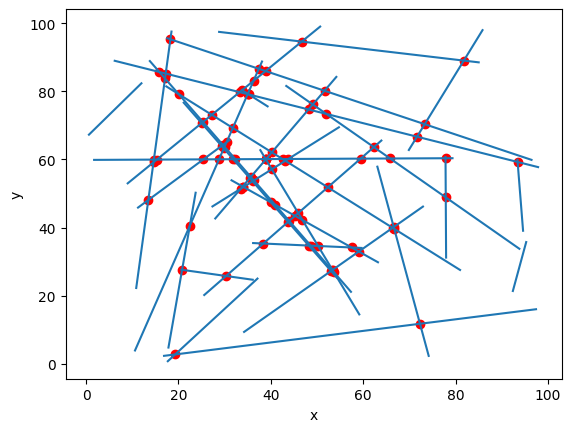

In [40]:
for i in test_examples:
    draw_segments(i)
    draw_intersecitons(i, find_intersections(i))

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.